# The Mechanical Cause of Box Beam's Bifurcation Break

***

In this notebook we demonstrate the mechanical cause of the bifurcation break observed for both the [unreinforced](06_Nonlinear_Buckling_Method_Verification.ipynb) and the [reinforced box beam](08_Nonlinear_Buckling_of_a_Reinforced_Box_Beam.ipynb) under a concentrated bending load applied at the tip.

* [Introduction](#introduction)
* [Unreinforced box beam](#unreinforced)
    * [Setup of the numerical model](#unreinforced-numerical-model)
    * [Linear buckling analysis](#unreinforced-linear-buckling)
    * [Nonlinear analysis](#unreinforced-nonlinear-analysis)
    * [Stress results](#unreinforced-stress-results)
* [Reinforced box beam](#reinforced)
    * [Setup of the numerical model](#reinforced-numerical-model)
    * [Linear buckling analysis](#reinforced-linear-buckling)
    * [Nonlinear analysis](#reinforced-nonlinear-analysis)
    * [Stress results](#reinforced-stress-results)
* [Conclusions](#conclusions)


## Introduction <a name="introduction"></a>

***

We make the hypothesis that bifurcation break is caused by an asymmetry of the internal loads about the midplane of the top skin, in addition to the global top-down asymmetry of the box beam introduced by the bending load.

We can observe this in the figure below, where we can see a side view of the section of an unreinforced box beam at the front-rear plane of symmetry. The concentrated tip load $P$ causes a deflection of our box beam that brings the top skin under compression and the bottom skin under tension.

In this configuration, the axial stresses in the spars at a given longitudinal section must vary from positive to negative along the local height. Also the axial stresses in the skins must have an analogous variation between their top and bottom planes. However, in this case the variation is between two positive values for the bottom skin and between two negative values for the top skin. As a consequence there is no symmetry of the stresses, and thus of the internal loads, about the midplane of the top skin, which causes the bifurcation point to break.

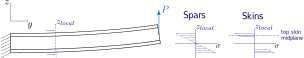

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '10_BoxBeamStresses.svg'))

We are going to test this hypothesis on both the unreinforced and the reinforced box beam configurations.

## Unreinforced box beam <a name="unreinforced"></a>

***

### Setup of the numerical model <a name="unreinforced-numerical-model"></a>

We consider an unreinforced box beam with the same geometry as the one used in our previous notebooks.

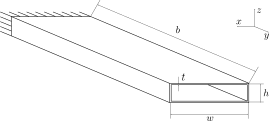

In [2]:
SVG(filename=os.path.join('resources', '04_BoxBeamGeometry.svg'))

In [3]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.2f} m\n- span: {b/1e3:.2f} m\n- height: {h/1e3:.2f} m\n- wall thickness: {t:.2f} mm')

Box beam dimensions:
- width: 1.00 m
- span: 4.50 m
- height: 0.20 m
- wall thickness: 4.00 mm


We do the same for the material properties.

In [4]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

We create a mesh of quadrilateral elements using the function `mesh_box_pyvista` from the `box_beam_utils` module. We prescribe an edge length of 86 mm based on the results of a previous [mesh convergence study](04_Nonlinear_Buckling_Box_Beam.ipynb).

In [5]:
from resources import box_beam_utils

edge_length = 86  # [mm]
unreinforced_box_beam_mesh = box_beam_utils.mesh_box_pyvista(width=w, span=b, height=h, edge_length=edge_length)
nodes_coordinates_array = unreinforced_box_beam_mesh.points
nodes_connectivity_matrix = unreinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

Now we create a base `BDF` object where we define fixed boundary conditions at the root of the box beam.

In [6]:
# Create BDF object
unreinforced_box_beam = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
# Print cards of BDF object
print(unreinforced_box_beam.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 1760

bdf.elements: 0
  CQUAD4   : 1728

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Then we apply a concentrated tip load at the center of the tip section as shown below. We use a RBE2 element to connect the nodes along the tip section to the node in the center.

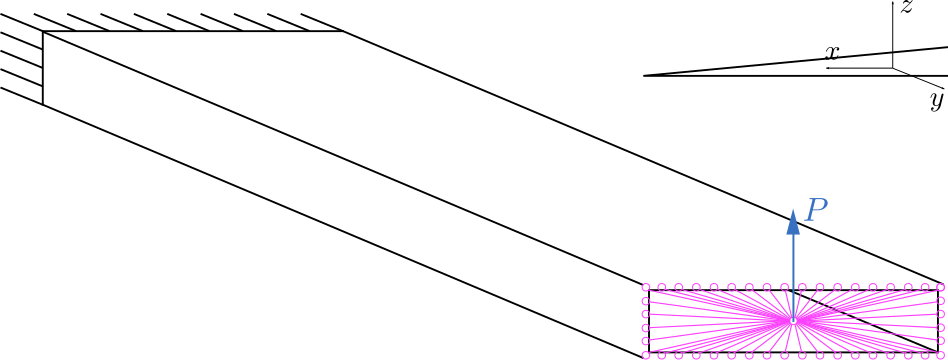

In [7]:
SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

In [8]:
import numpy as np
from resources import pynastran_utils

# Find id of tip nodes
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tolerance = edge_length/100
tip_nodes_ids = nodes_ids[np.abs(nodes_coordinates_array[:,1] - b) < tolerance]
# Add master node of tip section
tip_section_master_node_id = np.amax(nodes_ids) + 1
unreinforced_box_beam.add_grid(tip_section_master_node_id, [w/2, b, 0.])
# Add RBE2 to connect master node with outer nodes of tip rib
rbe2_eid = len(unreinforced_box_beam.elements) + 1
unreinforced_box_beam.add_rbe2(eid=rbe2_eid, gn=tip_section_master_node_id, cm='123456', Gmi=tip_nodes_ids)
# Add concentrated force
force_set_id = 11
force_direction = [0., 0., 1.]
pynastran_utils.add_unitary_force(bdf_object=unreinforced_box_beam, nodes_ids=[tip_section_master_node_id], set_id=force_set_id, direction_vector=force_direction)

### Linear buckling analysis <a name="unreinforced-linear-buckling"></a>

We use SOL 105 to calculate the linear buckling load and the corresponding buckling shape, in order to have a reference for the nonlinear analysis.

Buckling load: 1657 N
Buckling mode:


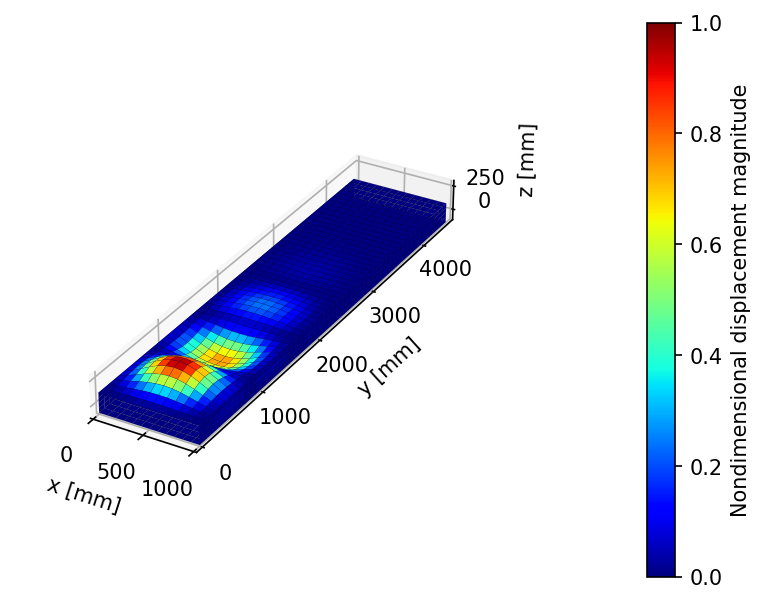

In [9]:
import matplotlib.pyplot as plt

# Define name of analysis directory
analysis_directory_name = '10_The_Mechanical_Cause_of_Bifurcation_Break'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Calculate linear buckling load and plot buckling shape
plt.rcParams['figure.dpi'] = 150  # set default dpi of figures
sol_105_buckling_load = box_beam_utils.calculate_linear_buckling_load(bdf_object=unreinforced_box_beam.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name='unreinforced_box_beam_linear_bukling', run_flag=True, plot_shape=True)

### Nonlinear analysis <a name="unreinforced-nonlinear-buckling"></a>

Now we set up our nonlinear analysis (SOL 106) with the arc-length method using the function `set_up_arc_length_method` from the `pynastran_utils` module. We use the set of parameters obtained from a [previous sensitivity study](08_Nonlinear_Buckling_of_a_Reinforced_Box_Beam.ipynb#nonlinear-analysis-parameters) on the nonlinear analysis parameters.

In [10]:
# Set up nonlinear analysis with arc-length method
pynastran_utils.set_up_arc_length_method(bdf_object=unreinforced_box_beam, ninc=100, eps_p=1e-3, eps_w=1e-7, maxalr=1.1, desiter=5, maxinc=100)

Let's define the magnitude of the applied load as twice the buckling load obtained by SOL 105 and let's create the corresponding subcase. We also add a case control command to store the stress results in the op2 file.

In [11]:
# Define total applied load
load_set_id = force_set_id+1
load_magnitude = sol_105_buckling_load*2
unreinforced_box_beam.add_load(sid=load_set_id, scale=1., scale_factors=[load_magnitude], load_ids=[force_set_id])
# Create subcase
subcase_id = 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam, subcase_id=subcase_id, load_set_id=load_set_id)
# Store stress results of all elements in the op2 file
unreinforced_box_beam.case_control_deck.subcases[0].add_result_type('STRESS', 'ALL', ['PLOT'])

We run the analysis and plot the load-displcacement diagram and the final deformation shape.

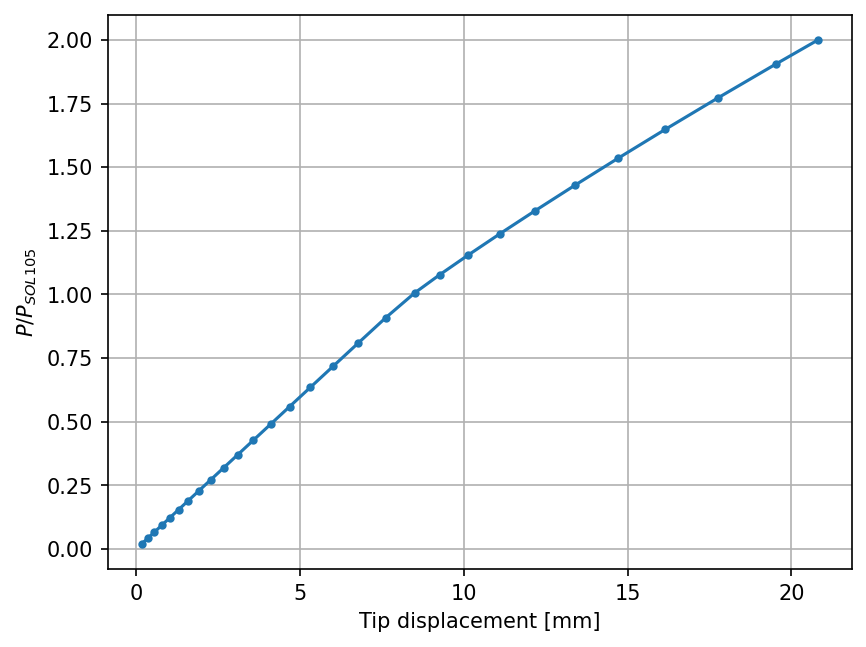

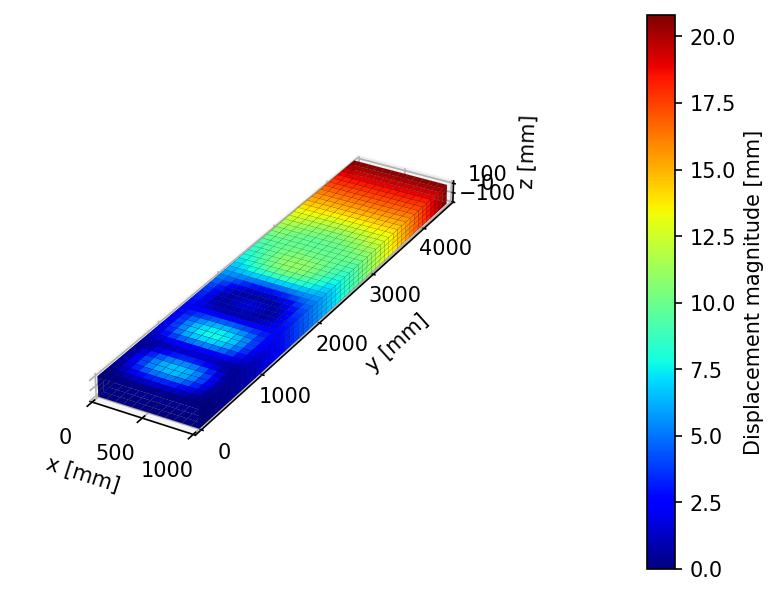

In [12]:
from pyNastran.op2.op2 import read_op2

# Run analysis
input_filename = 'unreinforced_box_beam_nonlinear_analysis'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=unreinforced_box_beam, bdf_filename=input_filename, run_flag=True)
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=False)
# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=tip_section_master_node_id)
# Select translation along z as the load and displacement components to plot
load_component_index = 2
displacement_component_index = 2
# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacements[1][:,displacement_component_index], loads[1][:, load_component_index]/sol_105_buckling_load, '.-')
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.grid()
plt.show()
# Plot final static deformation
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=subcase_id)
# Adjust number of ticks of x and z axes
ax.locator_params(axis='x', nbins=3)
ax.locator_params(axis='z', nbins=2)
# Adjust ticks label of y and z axes
ax.tick_params(axis='y', which='major', pad=20)
ax.tick_params(axis='z', which='major', pad=6)
# Adjust axis label y and z axes
ax.yaxis.labelpad = 60
ax.zaxis.labelpad = 10

As expected we find a change in the slope of the load-dislacement diagram at $P/P_{SOL 105}=1$ and a buckled-like shape for the final deformation of the structure.

### Stress results <a name="unreinforced-stress-results"></a>

Now we want to look at the axial stresses in the top skin at a given $y$ location to verify that there is no symmetry about the midplane. We consider the first load increment of the nonlinear analysis, approximately $P/P_{SOL 105}=0.02$, as if the symmetry of the internal loads breaks it should do so from the start of the loading process. Since Nastran's stress output is given in terms of the element's local $x$ and $y$ axes, we first need to understand the orientation of the elements' coordinate system with respect to the global one. For this reason we plot all the elements of the top skin and the coordinate system of the first element (lowest Nastran element id), where the $x$ axis is colored in red, the $y$ axis is colored in green and the $z$ axis is colored in blue. We only need to look at the coordinate system of one of the elements because the mesh creation process enforces all elements of the same structural part (top skin in this case) to have the same coordinate system as defined by Nastran's convention for CQUAD4 elements.

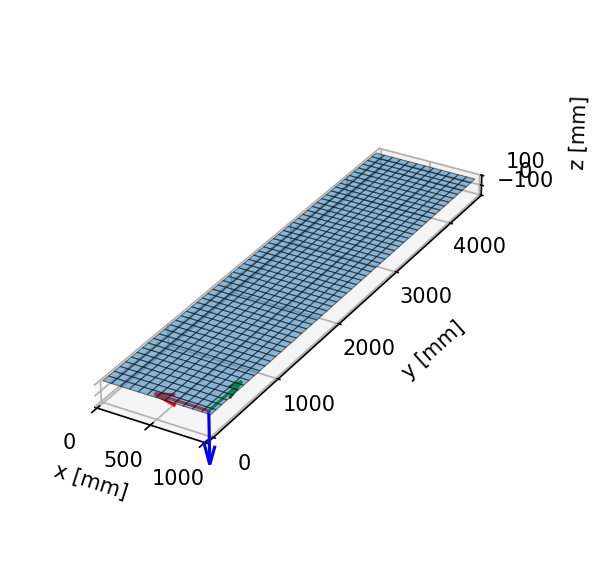

In [13]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Find elements' nodes and centroid coordinates
elements_nodes_xyz = np.stack([e.get_node_positions() for e in op2_output.elements.values()], axis=0)
elements_centroid_xyz = np.sum(elements_nodes_xyz, axis=1)/4
# Find top skin elements' nodes coordinates
top_skin_indices = np.where(np.abs(elements_centroid_xyz[:,2]-h/2)<tolerance)[0]
top_skin_elements_nodes_xyz = elements_nodes_xyz[top_skin_indices, :, :]
# Find the coordinate system of an element of the top skin
elements_ids = np.arange(len(op2_output.elements)) + 1
element_coordinate_system = op2_output.elements[elements_ids[top_skin_indices[0]]].element_coordinate_system()
# Create figure and axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot elements
pc = Poly3DCollection(top_skin_elements_nodes_xyz, linewidths=.5, alpha=.5)
pc.set_edgecolor('k')
ax.add_collection3d(pc)
# Plot element coordinate system
arrow_length = 500
arrowhead_length_ratio = .4
ax.quiver(element_coordinate_system[1][0], element_coordinate_system[1][1], element_coordinate_system[1][2],
               element_coordinate_system[2][0], element_coordinate_system[2][1], element_coordinate_system[2][2],
               color='r', length=arrow_length, arrow_length_ratio=arrowhead_length_ratio)  # x-axis
ax.quiver(element_coordinate_system[1][0], element_coordinate_system[1][1], element_coordinate_system[1][2],
               element_coordinate_system[3][0], element_coordinate_system[3][1], element_coordinate_system[3][2],
               color='g', length=arrow_length, arrow_length_ratio=arrowhead_length_ratio)  # y-axis
ax.quiver(element_coordinate_system[1][0], element_coordinate_system[1][1], element_coordinate_system[1][2],
               element_coordinate_system[4][0], element_coordinate_system[4][1], element_coordinate_system[4][2],
               color='b', length=arrow_length, arrow_length_ratio=arrowhead_length_ratio)  # z-axis
# Set axes label
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
# Set aspect ratio
bounds = np.array([
    [np.amin(elements_nodes_xyz[:, :, 0]), np.amax(elements_nodes_xyz[:, :, 0])],
    [np.amin(elements_nodes_xyz[:, :, 1]), np.amax(elements_nodes_xyz[:, :, 1])],
    [np.amin(elements_nodes_xyz[:, :, 2]), np.amax(elements_nodes_xyz[:, :, 2])]])
ax.set_box_aspect([x[1]-x[0] for x in list(bounds)])
# Set axes limits
ax.set_xlim(bounds[0, :])
ax.set_ylim(bounds[1, :])
ax.set_zlim(bounds[2, :])
# Adjust number of ticks of x and z axes
ax.locator_params(axis='x', nbins=3)
ax.locator_params(axis='z', nbins=2)
# Adjust ticks label of y- and z-axis
ax.tick_params(axis='y', which='major', pad=30)
ax.tick_params(axis='z', which='major', pad=10)
# Adjust axis label y and z axes
ax.yaxis.labelpad = 80
ax.zaxis.labelpad = 20
# Show plot
plt.show()

We can observe that the elements' local $y$ axis is aligned with the global $y$ axis, while the local $x$ and $z$ axes point towards the opposite direction with respect to the global axes. Since we are interested in the axial stress, we are going to look at the stress along the $y$ axis of the elements.

We select $y=400$ mm as the location where we want to inspect the axial stresses top skin because it approximately corresponds to the displacement peak of the first "bubble" in the deformation plot. Then we plot the axial stress $\sigma_y$ at the top and the bottom plane for all elements along the $y=400$ mm section.

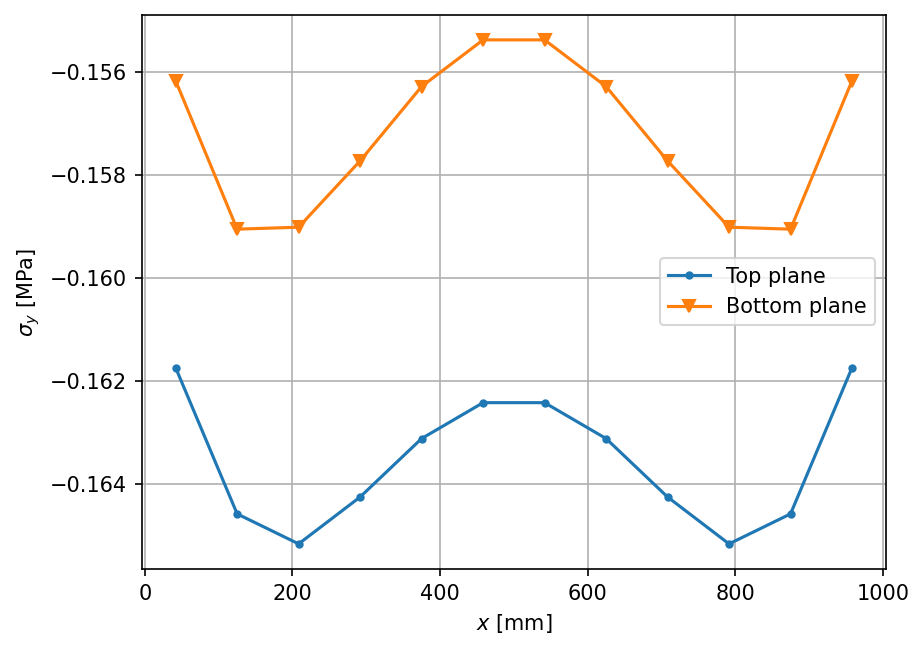

In [14]:
# Find indices of the elements' nodes coordinates array corresponding to the elements along the prescribed section
stress_profile_y_location = 400  # [mm]
stress_profile_indices = np.where([(np.amin(e[:, 1]) < stress_profile_y_location) &
                                   (np.amax(e[:, 1]) > stress_profile_y_location) &
                                   (all(np.abs(e[:, 2] - h/2) < tolerance)) for e in elements_nodes_xyz])[0]
# Find x location of the elements' centroid along the prescribed section
elements_centroid_x = elements_centroid_xyz[stress_profile_indices, 0]
# Find stresses data of the elements along the prescribed section
stress_profile_data = np.stack([op2_output.cquad4_stress[subcase_id].data[0, np.where(op2_output.cquad4_stress[subcase_id].element_node == eid)[0], :] for eid in elements_ids[stress_profile_indices]], axis=0)
# Plot axial stress vs x coordinate of the element for both the top and bottom plane
_, ax = plt.subplots()
ax.plot(elements_centroid_x, stress_profile_data[:, 0, 2], '.-', label='Top plane')
ax.plot(elements_centroid_x, stress_profile_data[:, 1, 2], 'v-', label='Bottom plane')
ax.legend()
plt.xlabel('$x$ [mm]')
plt.ylabel('$\sigma_y$ [MPa]')
plt.grid()
plt.show()

We observe that the stress at the top plane is more negative than the one at the bottom plane, as expected, implying an asymmetry about the midplane of the top skin.

## Reinforced box beam <a name="reinforced"></a>

***

### Setup of the numerical model <a name="reinforced-numerical-model"></a>

We consider the same geometry used for the unreinforced box beam and prescribe the same ribs spacing employed in previous notebooks.

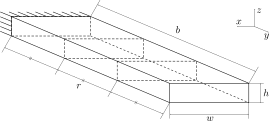

In [15]:
SVG(filename=os.path.join('resources', '08_ReinforcedBoxBeamGeometry.svg'))

In [16]:
# Prescribed spacing
ribs_spacing = w/2
# Number of ribs based on prescribed spacing
no_ribs = int(np.ceil(b/ribs_spacing)) + 1
# Find prescribed ribs location
ribs_y_locations = np.linspace(0, b, no_ribs)
print('Ribs y position [mm]:')
np.set_printoptions(precision=0)
print(ribs_y_locations)

Ribs y position [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


We create a mesh of quadrilateral elements using the function `mesh_box_beam_pyvista` from the `box_beam_utils` module. We prescribe an edge length of 49 mm based on the results of a previous [mesh convergence study](08_Nonlinear_Buckling_of_a_Reinforced_Box_Beam.ipynb).

In [17]:
edge_length = 49  # [mm]
reinforced_box_beam_mesh = box_beam_utils.mesh_box_beam_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h, edge_length=edge_length)
nodes_coordinates_array = reinforced_box_beam_mesh.points
nodes_connectivity_matrix = reinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

We keep the same material properties used for the unreinforced box beam and create a base `BDF` object with fixed boundary conditions at the box beam root.

In [18]:
# Create BDF object
reinforced_box_beam = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
# Print cards of BDF object
print(reinforced_box_beam.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 7154

bdf.elements: 0
  CQUAD4   : 7368

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Then we apply a concentrated tip load in an analogous way as done for the unreinforced box beam. This time we use a RBE3 element to connect the nodes along the outer edges of the tip section to the node in the center as the rigidity of the tip is enforced by the presence of a physical rib.

In [19]:
# Find outer nodes of tip rib
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tolerance = edge_length/100
outer_tip_nodes_ids = nodes_ids[(np.abs(nodes_coordinates_array[:, 1] - b) < tolerance) & ((nodes_coordinates_array[:, 0] < tolerance) | (np.abs(nodes_coordinates_array[:, 0] - w) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] - h/2) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] + h/2) < tolerance))]
# Add master node of tip section
tip_section_master_node_id = np.amax(nodes_ids) + 1
reinforced_box_beam.add_grid(tip_section_master_node_id, [w/2, b, 0.])
# Add RBE3 to connect master node with outer nodes of tip rib
rbe3_eid = len(reinforced_box_beam.elements) + 1
reinforced_box_beam.add_rbe3(eid=rbe3_eid, refgrid=tip_section_master_node_id, refc='123456', weights=[1.]*len(outer_tip_nodes_ids), comps=['123456']*len(outer_tip_nodes_ids), Gijs=outer_tip_nodes_ids)
# Add concentrated force
pynastran_utils.add_unitary_force(bdf_object=reinforced_box_beam, nodes_ids=[tip_section_master_node_id], set_id=force_set_id, direction_vector=force_direction)

### Linear buckling analysis <a name="reinforced-linear-buckling"></a>

Once again, we use SOL 105 to calculate the linear buckling load and the corresponding buckling shape.

Buckling load: 3094 N
Buckling mode:


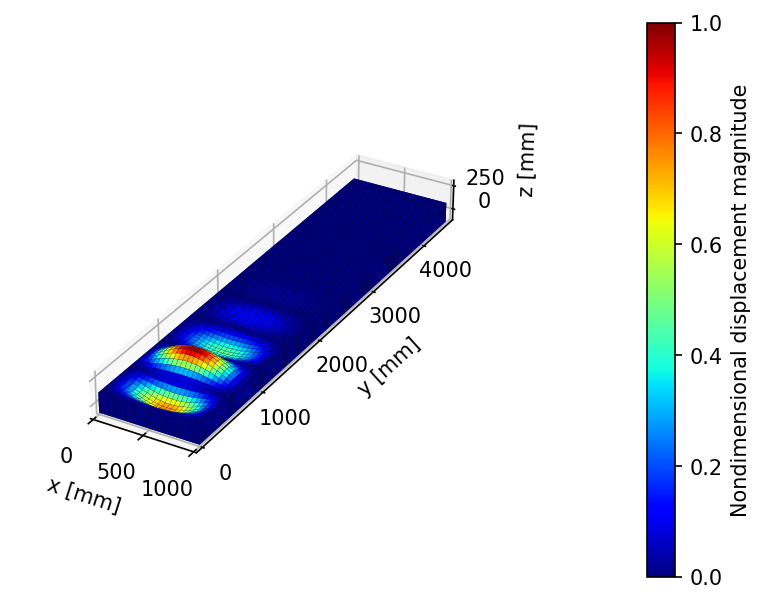

In [20]:
sol_105_buckling_load = box_beam_utils.calculate_linear_buckling_load(bdf_object=reinforced_box_beam.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name='reinforced_box_beam_linear_bukling', run_flag=True, plot_shape=True)

### Nonlinear analysis <a name="reinforced-nonlinear-model"></a>

We initialize the nonlinear analysis with the arc-length method setting the same parameters used previously and we create a subcase with an applied load equal to twice the linear buckling load.

In [21]:
# Set up nonlinear analysis with arc-length method
pynastran_utils.set_up_arc_length_method(bdf_object=reinforced_box_beam, ninc=100, eps_p=1e-3, eps_w=1e-7, maxalr=1.1, desiter=5, maxinc=100)
# Store stress results of all elements in the op2 file
reinforced_box_beam.case_control_deck.subcases[0].add_result_type('STRESS', 'ALL', ['PLOT'])
# Define total applied load
load_magnitude = sol_105_buckling_load*2
reinforced_box_beam.add_load(sid=load_set_id, scale=1., scale_factors=[load_magnitude], load_ids=[force_set_id])
# Create subcase
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam, subcase_id=subcase_id, load_set_id=load_set_id)

Let's run the analysis and plot the load-displacement diagram and the final deformation shape.

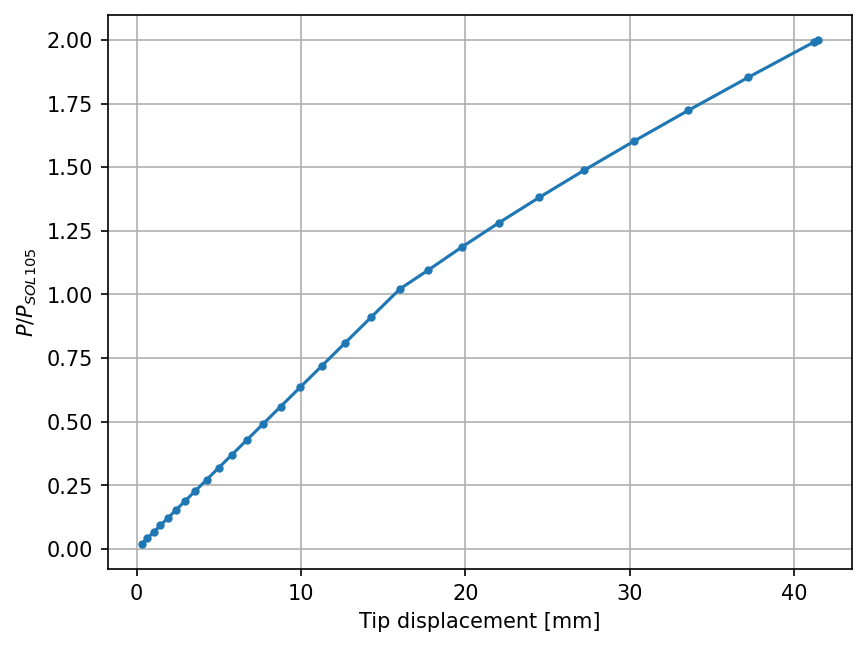

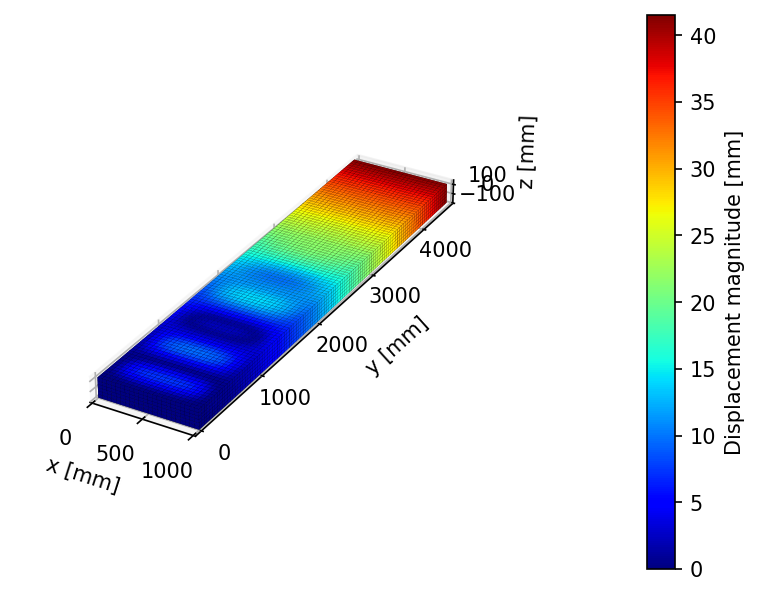

In [22]:
# Run analysis
input_filename = 'reinforced_box_beam_nonlinear_analysis'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=reinforced_box_beam, bdf_filename=input_filename, run_flag=True)
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=False)
# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=tip_section_master_node_id)
# Select translation along z as the load and displacement components to plot
load_component_index = 2
displacement_component_index = 2
# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacements[1][:,displacement_component_index], loads[1][:, load_component_index]/sol_105_buckling_load, '.-')
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.grid()
plt.show()
# Plot final static deformation
_, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=subcase_id)
# Adjust number of ticks of x and z axes
ax.locator_params(axis='x', nbins=3)
ax.locator_params(axis='z', nbins=2)
# Adjust ticks label of y and z axes
ax.tick_params(axis='y', which='major', pad=20)
ax.tick_params(axis='z', which='major', pad=6)
# Adjust axis label y and z axes
ax.yaxis.labelpad = 60
ax.zaxis.labelpad = 10

Also in this case we observe a change in the slope of the load-displacement diagram approximately at $P/P_{SOL 105}=1$ and a buckled-like shape for the final deformation of the structure.

### Stress results <a name="reinforced-stress-results"></a>

Analogously to the unreinforced box beam case, we plot the axial stress $\sigma_y$ along the prescribed section for both the top and bottom plane. We consider again the section at $y=400$ mm.

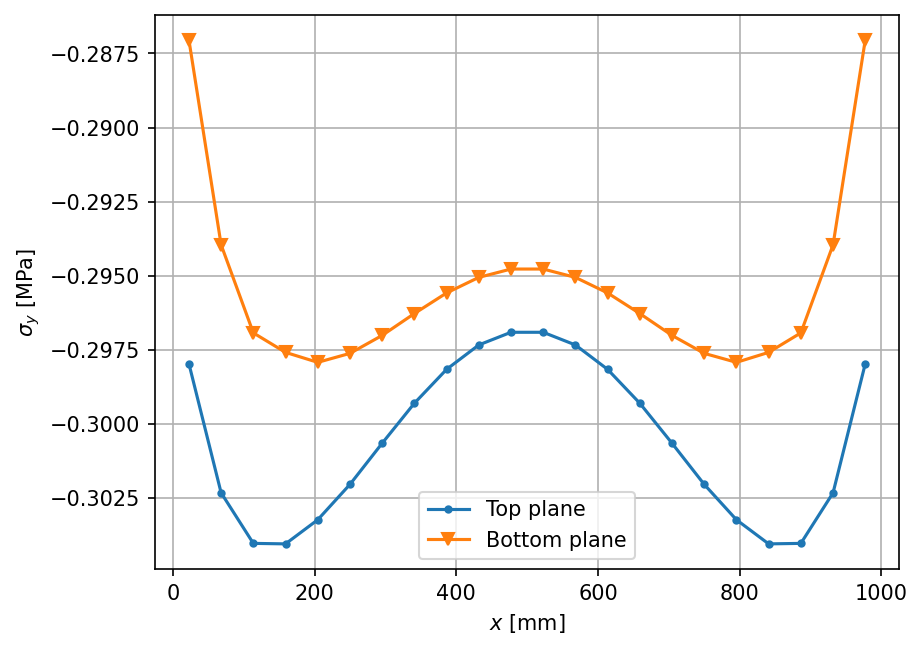

In [23]:
# Find indices of the elements' nodes coordinates array corresponding to the elements along the prescribed section
elements_nodes_xyz = np.stack([e.get_node_positions() for e in op2_output.elements.values()], axis=0)
elements_centroid_xyz = np.sum(elements_nodes_xyz, axis=1)/4
stress_profile_indices = np.where([(np.amin(e[:, 1]) < stress_profile_y_location) &
                                   (np.amax(e[:, 1]) > stress_profile_y_location) &
                                   (all(np.abs(e[:, 2] - h/2) < tolerance)) for e in elements_nodes_xyz])[0]
# Find corresponding elements' ids
stress_profile_element_ids = stress_profile_indices + 1
# Find x location of the elements' centroid along the prescribed section
elements_centroid_x = elements_centroid_xyz[stress_profile_indices, 0]
# Find stresses data of the elements along the prescribed section
stress_profile_data = np.stack([op2_output.cquad4_stress[subcase_id].data[0, np.where(op2_output.cquad4_stress[subcase_id].element_node == eid)[0], :] for eid in stress_profile_element_ids], axis=0)
# Plot axial stress vs x coordinate of the element for both the top and bottom plane
_, ax = plt.subplots()
ax.plot(elements_centroid_x, stress_profile_data[:, 0, 2], '.-', label='Top plane')
ax.plot(elements_centroid_x, stress_profile_data[:, 1, 2], 'v-', label='Bottom plane')
ax.legend()
plt.xlabel('$x$ [mm]')
plt.ylabel('$\sigma_y$ [MPa]')
plt.grid()
plt.show()

Also in this case the axial stress varies from a more negative value at the top plane to a less negative value at the bottom plane, as expected. Once again this implies an asymmetry of the internal load of the top skin about its midplane.

## Conclusions <a name="conclusions"></a>

***

In this notebook we have demonstrated that the bending load used in previous notebooks introduces an asymmetry in the internal load of the top skin of the box beam. This has been observed for both the unreinforced and the reinforced cases. As a consequence this corroborates the hypothesis that the bifurcation break observed in the previous notebooks has a mechanical cause. In order to definitely prove this, in our next notebook we will investigate the behaviour of the box beam under a pure compression load applied at the center of the tip section, which is supposed not to break any symmetry.

***

The cell below executes the style for this notebook. We use a slightly modified version of the custom style found on the GitHub of [barbagroup](https://github.com/barbagroup), [@LorenaABarba](https://twitter.com/LorenaABarba).

In [24]:
from IPython.core.display import HTML
def css_styling():
    styles = open(os.path.join(os.pardir, 'styles', 'custom.css'), 'r').read()
    return HTML(styles)
css_styling()